In this notebook I will give an overview on how the pepskit code handles infinite peps.

In [ ]:
using MPSKit,PEPSKit,TensorKit,OptimKit,Plots

The infinite peps constructor takes a 2 dimensional array of peps tensors. The following creates a 2 by 2 unit cell peps.

In [2]:
data = map(Iterators.product(1:2,1:2)) do (i,j)
    TensorMap(rand,ComplexF64,ℂ^2*ℂ^2*(ℂ^2)'*(ℂ^2)',(ℂ^2)')
end

peps = InfPEPS(data);

To actually calculate anything meaningful, we need access to the peps environments. This object can be created by calling environments, and PEPSKit provides some useful methods to access the boundary tensors.

One minor caveat, environments() also normalizes the peps tensors behind the scenes. It's much easier to work with our algorithms if the peps is normalized...

In [3]:
env = environments(peps);
codomain(AC(env,North,2,2)) ← domain(AC(env,North,2,2))

┌ Info: vumps @iteration 1 galerkin = 8.491522850346072
└ @ MPSKit /home/maarten/.julia/packages/MPSKit/8k96H/src/algorithms/statmech/vumps.jl:78
┌ Info: vumps @iteration 1 galerkin = 4.406235085809189
└ @ MPSKit /home/maarten/.julia/packages/MPSKit/8k96H/src/algorithms/statmech/vumps.jl:78
┌ Info: vumps @iteration 1 galerkin = 5.512864752142594
└ @ MPSKit /home/maarten/.julia/packages/MPSKit/8k96H/src/algorithms/statmech/vumps.jl:78
┌ Info: vumps @iteration 1 galerkin = 5.342147914059468
└ @ MPSKit /home/maarten/.julia/packages/MPSKit/8k96H/src/algorithms/statmech/vumps.jl:78
┌ Info: vumps @iteration 2 galerkin = 0.2767815957430363
└ @ MPSKit /home/maarten/.julia/packages/MPSKit/8k96H/src/algorithms/statmech/vumps.jl:78
┌ Info: vumps @iteration 2 galerkin = 0.09513838224166228
└ @ MPSKit /home/maarten/.julia/packages/MPSKit/8k96H/src/algorithms/statmech/vumps.jl:78
┌ Info: vumps @iteration 2 galerkin = 0.14799677234856387
└ @ MPSKit /home/maarten/.julia/packages/MPSKit/8k96H/src/algor

(ℂ^1 ⊗ ℂ^2 ⊗ (ℂ^2)') ← ℂ^1

As you can see, by default the environment tensors are trivial chi = 1. There is no easy way to change this, at the moment you have to make use of the MPSKit finalize - changebonds machinery.

In [4]:
function bound_finalize(iter,state,ham,pars)
    maxD = 20;
    
    # check every virtual bond dimension and see if it's larger then maxD
    bigenough = reduce((a,(i,j))-> a && dim(virtualspace(state,i,j))>=maxD,
        Iterators.product(1:size(state,1),1:size(state,2)),init=true)
    
    if !bigenough 
        (state,pars) = changebonds!(state,ham,OptimalExpand(trscheme=truncdim(1)),pars)
    end
    
    return (state,pars,true)
end
env = environments(peps,alg=Vumps(verbose=false,finalize! = bound_finalize))

codomain(AC(env,North,2,2)) ← domain(AC(env,North,2,2))

(ℂ^17 ⊗ ℂ^2 ⊗ (ℂ^2)') ← ℂ^17

It is now very easy to calculate the norm of our infinite mps in a bunch of different ways

In [5]:
@tensor fp1RL(env,North,1,1)[1,2,3,4]*fp1LR(env,South,0,1)[4,2,3,1]

1.0000000249863832 - 2.8421560001488864e-15im

In [6]:
@tensor fp0RL(env,East,1,1)[1,2]*fp0LR(env,West,0,2)[2,1]

1.0000000000000002 + 9.941848676866968e-16im

In [7]:
@tensor fp1LR(env,North,2,2)[1,2,3,4]*
        corner(env,NorthEast,2,2)[4,5]*
        fp1LR(env,East,2,2)[5,6,7,8]*
        corner(env,SouthEast,2,2)[8,9]*
        fp1LR(env,South,2,2)[9,10,11,12]*
        corner(env,SouthWest,2,2)[12,13]*
        fp1LR(env,West,2,2)[13,14,15,16]*
        corner(env,NorthWest,2,2)[16,1]*
        peps[2,2][14,10,6,2,17]*
        conj(peps[2,2][15,11,7,3,17])

0.9999999999999989 + 4.685903009070325e-15im

Anyway, this probably makes very little sense unless you know the ins and outs already. It should clarify why things like measuring expectation values require passing in the environment object itself :

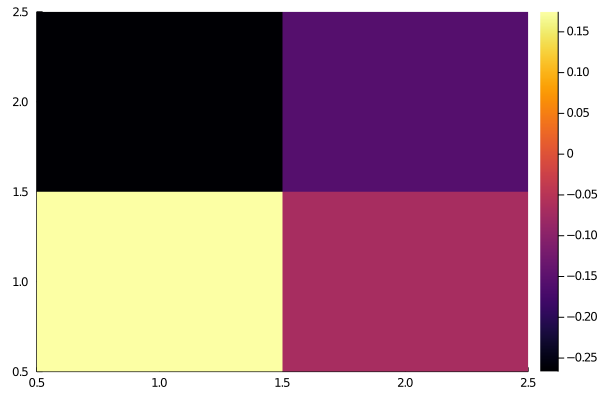

In [8]:
sz = TensorMap([1 0;0 -1],ℂ^2,ℂ^2)
heatmap(real.(expectation_value(env,sz)))

In [9]:
ham = nonsym_nn_xxz_ham();
expectation_value(env,ham)

1.8813666795433435 + 3.3863146374677545e-15im

To numerically approximate the gradient, we can use a number of different techniques. One such approximation is known as the channel approximation. To calculate these channels, you can simply call

In [10]:
chan = channels(env,ham);

While this object isn't very exciting in and of itself, we can use it to get the effective hamiltonian and gram matrix:

In [11]:
(H_eff,N_eff) = PEPSKit.effectivehn(chan,2,2)
codomain(H_eff) ← domain(H_eff)

(ℂ^2 ⊗ ℂ^2 ⊗ (ℂ^2)' ⊗ (ℂ^2)' ⊗ ℂ^2) ← (ℂ^2 ⊗ ℂ^2 ⊗ (ℂ^2)' ⊗ (ℂ^2)' ⊗ ℂ^2)

Let's calculate the gradient : 

In [12]:
v = permute(peps[2,2],(1,2,3,4,5))
gradient = H_eff*v - dot(v,H_eff*v)*N_eff*v
norm(gradient)

0.039002881635267904

The energy can also be minimized using algorithms from another package - OptimKit.

In [13]:
optalg = LBFGS(linesearch = HagerZhangLineSearch(ϵ = 1e-3),maxiter=500,verbosity=2,gradtol=1e-2)

(gs_state,gs_chan,delta) = find_groundstate(peps,ham,optalg,chan);

┌ Info: LBFGS: initializing with f = 0.470341669886, ‖∇f‖ = 2.5357e+00
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:35
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:17
┌ Info: trying stepsize 5.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:17
┌ Info: trying stepsize 25.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:17
┌ Info: trying stepsize 16.30877656756019
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:17
┌ Info: LBFGS: iter    1: f = -0.342671125177, ‖∇f‖ = 4.0396e+00, α = 1.63e+01, m = 0, nfg = 4
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:17
┌ Info: LBFGS: iter    2: f = -0.452682794921, ‖∇f‖ = 2.1883e+00, α = 1.00e+00, m = 1, nfg = 1
└ @ OptimKit /home/maarten/.julia/pa

┌ Info: LBFGS: iter   26: f = -0.660155511846, ‖∇f‖ = 1.9026e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:17
┌ Info: LBFGS: iter   27: f = -0.660163731995, ‖∇f‖ = 1.1872e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:17
┌ Info: LBFGS: iter   28: f = -0.660169634839, ‖∇f‖ = 1.0535e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:17
┌ Info: LBFGS: iter   29: f = -0.660176511744, ‖∇f‖ = 1.0712e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76


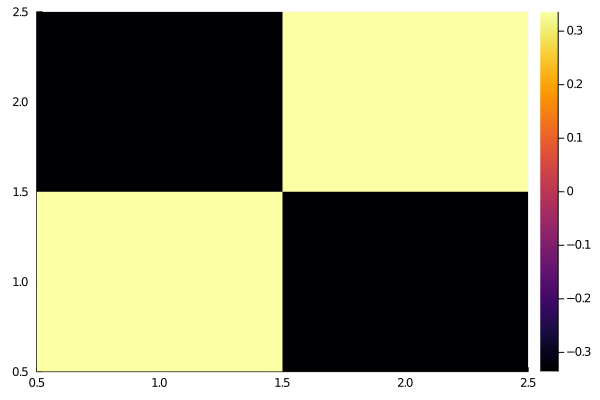

In [14]:
heatmap(real.(expectation_value(gs_chan,sz)))